# **Yao’s Protocol vs Not Privacy-Preserving Computation**




In [1]:
import numpy as np
import random
import hashlib
import matplotlib.pyplot as plt
import time

Global auxiliary variable:

In [2]:
n = 4

## Garbled Gate's Class:

In [3]:
class GarbledGate:
    def __init__(self, garbled_gate, idx_input_fst: int, idx_input_snd: int, is_const: bool):
      self.garbled_gate = garbled_gate
      self.idx1 = idx_input_fst
      self.idx2 = idx_input_snd
      self.is_const = is_const

## OT - 2:

In [4]:
class OT:
    def __init__(self, p, q, g):
      self.p = p  # Prime modulus
      self.q = q  # Order of the cyclic group
      self.g = g  # Generator

      self.pk0 = None
      self.pk1 = None

    def Gen(self):
      sk = random.SystemRandom().randrange(0, self.q)  # Secret key
      pk = pow(self.g, sk, self.p)  # Public key
      return pk, sk

    def Enc(self, m, pk):
      r = random.SystemRandom().randrange(0, self.q)  # Random value
      c1 = pow(self.g, r, self.p)
      c2 = (m * pow(pk, r, self.p)) % self.p
      return c1, c2

    def Dec(self, c, sk):
      c1, c2 = c
      m = (c2 * pow(c1, -sk, self.p)) % self.p
      return m

    def OGen(self, r):
      s = random.SystemRandom().randrange(0, self.p)  # Random value
      h = pow(s, 2, self.p)
      return h

## Alice's Class:

In [5]:
class Alice:
    """
    Attributes:
      - param x: Alice's input.
      - param circuit: an object of circuit that represents a boolean circuit.
      - param labels: all labels.
      - param const_labels: constants' labels.
    """

    def __init__(self, x):
      self.x = x
      self.circuit = np.array([[(1,0,0,4), (1,0,0,5), (1,0,1,4), (1,0,1,5), (1,0,2,6), (1,0,2,7), (1,0,3,6), (1,0,3,7)],
                             [(0,1,0,0), (1,0,1,2), (0,0,1,2), (0,1,3,0), (0,1,4,0), (1,0,5,6), (0,0,5,6), (0,1,7,0)],
                             [(1,0,0,1), (0,0,0,1), (0,1,2,0), (0,1,3,0), (1,0,4,5), (0,0,4,5), (0,1,6,0), (0,1,7,0)],
                             [(1,0,0,4), (0,0,0,4), (1,0,1,5), (0,0,1,5), (1,0,2,6), (0,0,2,6), (1,0,3,7), (0,0,3,7)],
                             [(0,1,0,0), (0,1,1,0), (0,1,2,0), (0,1,3,0), (0,1,4,0), (1,0,5,6), (0,0,5,6), (0,1,7,0)],
                             [(0,1,0,0), (0,1,1,0), (0,1,2,0), (0,1,3,0), (0,0,4,5), (0,1,6,0), (0,1,7,0)],
                             [(0,1,0,0), (0,1,1,0), (0,1,2,0), (1,0,3,4), (0,0,3,4), (0,1,5,0), (0,1,6,0)],
                             [(0,1,0,0), (0,1,1,0), (0,0,2,3), (0,1,4,0), (0,1,5,0), (0,1,6,0)],
                             [(0,1,0,0), (1,0,1,2), (0,0,1,2), (0,1,3,0), (0,1,4,0), (0,1,5,0)],
                             [(0,0,0,1), (0,1,2,0), (0,1,3,0), (0,1,4,0), (0,1,5,0)],
                             [(1,0,0,1), (0,0,0,1), (0,1,2,0)],
                             [(0,0,0,1), (0,1,2,0)],
                             [(1,0,0,1), (0,0,0,1)],
                             [(0,0,0,1)]], dtype=object)
      self.labels = np.empty_like(np.append(self.circuit, [1]))
      self.const_labels = []

    def GenerateLabels(self):
      """
        Given a circuit, generate the respectively labels to the garbled circuit.
      """
      input_size = 2 * n
      self.labels[0] = self.MakeLayerLabel(num_labels=input_size)
      for idx, layer in enumerate(self.circuit):
        self.labels[idx + 1] = self.MakeLayerLabel(len(layer))
      return

    def MakeLayerLabel(self, num_labels):
      """
        Generate labels for a specific layer.

        Attributes:
          - param num_labels: the number of labels in the layer.
        Return:
          - layer_label: all labels for the specific layer.
      """
      layer_label = np.empty((num_labels, 2), dtype=object)
      for i in range(num_labels):
        layer_label[i, 0] = np.array2string(np.random.randint(0, 2, size=128), separator='')[1:-1].replace('\n', '').replace(' ', '')
        layer_label[i, 1] = np.array2string(np.random.randint(0, 2, size=128), separator='')[1:-1].replace('\n', '').replace(' ', '')
      return layer_label

    def BuildGarbledCircuit(self):
      """
        Given a circuit & labels, build the respectively labels to the garbled circuit.
      """
      self.garbled_circuit = np.empty_like(self.circuit)
      for idx_layer, layer in enumerate(self.circuit):
        self.garbled_circuit[idx_layer] = np.empty(len(self.circuit[idx_layer]), dtype=object)
        for idx_gate, gate in enumerate(layer):
          labels_input_fst = self.labels[idx_layer][gate[2]]
          if gate[1]:
            labels_input_snd = [np.array2string(np.random.randint(0, 2, size=128), separator='')[1:-1].replace('\n', '').replace(' ', ''), np.array2string(np.random.randint(0, 2, size=128), separator='')[1:-1].replace('\n', '').replace(' ', '')]
            self.const_labels.append(labels_input_snd[gate[3]])
          else:
            labels_input_snd = self.labels[idx_layer][gate[3]]
          labels_output = self.labels[idx_layer + 1][idx_gate]
          garbled_gate = self.BuildGarbledGate(gate[0], labels_input_fst, labels_input_snd, labels_output)

          # create the node
          if gate[1]:
            self.garbled_circuit[idx_layer][idx_gate] = GarbledGate(garbled_gate, gate[2], len(self.const_labels) - 1, bool(gate[1]))
          else:
            self.garbled_circuit[idx_layer][idx_gate] = GarbledGate(garbled_gate, gate[2], gate[3], bool(gate[1]))
      return

    def BuildGarbledGate(self, operation, labels_input_fst, labels_input_snd, labels_output):
      """
        Given a boolean circuit, build a garbled circuit.

        Attributes:
          - param operation: 1 if the operation of the gate is "AND" and 0 if is "XOR".
          - param labels_input_fst: 2 input labels.
          - param labels_input snd: 2 input labels.
          - param labels_output: 2 output labels.
        Return:
          - garbled_gate: 4 possible output labels.
      """
      garbled_gate = np.empty(4, dtype=object)
      if operation: # and
        garbled_gate[0] = self.EncryptOutput(labels_input_fst[0], labels_input_snd[0], labels_output[0])
        garbled_gate[1] = self.EncryptOutput(labels_input_fst[0], labels_input_snd[1], labels_output[0])
        garbled_gate[2] = self.EncryptOutput(labels_input_fst[1], labels_input_snd[0], labels_output[0])
        garbled_gate[3] = self.EncryptOutput(labels_input_fst[1], labels_input_snd[1], labels_output[1])
      else: # xor
        garbled_gate[0] = self.EncryptOutput(labels_input_fst[0], labels_input_snd[0], labels_output[0])
        garbled_gate[1] = self.EncryptOutput(labels_input_fst[0], labels_input_snd[1], labels_output[1])
        garbled_gate[2] = self.EncryptOutput(labels_input_fst[1], labels_input_snd[0], labels_output[1])
        garbled_gate[3] = self.EncryptOutput(labels_input_fst[1], labels_input_snd[1], labels_output[0])
      return garbled_gate

    def EncryptOutput(self, label_input_fst, label_input_snd, label_output):
      """
        Given 2 input labels, encrypt the result of gate.

        Attributes:
          - param label_input_fst: the first input label.
          - param label_input_snd: the second input label.
          - param label_output: the output label.
        Return:
          - encrypted_output: the encrypted output label.
      """
      binary_string = hashlib.sha256(label_input_fst.encode('utf-8') + label_input_snd.encode('utf-8'))
      input_bytes = binary_string.digest()
      hash_object = hashlib.sha256(input_bytes)
      hash_binary_string = hash_object.digest()
      H = ''.join(format(byte, '08b') for byte in hash_binary_string)
      M = label_output + '0' * 128
      H = np.array([bool(int(bit)) for bit in H])
      M = np.array([bool(int(bit)) for bit in M])
      x = np.logical_xor(H, M).astype(int)
      encrypted_output = ''.join(str(bit) for bit in x)
      return encrypted_output

    def SendCircuitAndGarbledInputs(self):
      """
        Send the garbled circuit, Alice's garbled labels and constants' labels.

        Returns:
          - garbled_circuit: the garbled circuit.
          - garbled_inputs_Alice: Alice's garbled labels.
          - const_labels: the constants' labels.
      """
      garbled_inputs_Alice = []
      for i, x_i in enumerate(self.x):
        garbled_inputs_Alice.append(self.labels[0][i][x_i])
      return self.garbled_circuit, garbled_inputs_Alice, self.const_labels

    def Sender(self, OT, i):
      """
        Sender's function.

        Attributes:
          - param OT:  an object of type 1-out-of-2 Oblivious Transfer.
          - param i: the index in Bob's input.
        Returns:
          - c0: Enc(m0, pk0).
          - c1: Enc(m1, pk1).
      """
      m0 = self.labels[0][n + i][0]            # Sender's message 0
      m1 = self.labels[0][n + i][1]            # Sender's message 1

      binary_number = int(m0, 2)
      m0_binary = '0b' + format(binary_number, '0>128b')
      m0 = int(m0_binary, 2)

      binary_number = int(m1, 2)
      m1_binary = '0b' + format(binary_number, '0>128b')
      m1 = int(m1_binary, 2)

      c0 = OT.Enc(m0, OT.pk0)  # Encrypt message 0 using public key for choice 0
      c1 = OT.Enc(m1, OT.pk1)  # Encrypt message 1 using modified public key for choice 1
      return c0, c1

    def ReceiveOutput(self, output_label):
      """
        Receive the output label.

        Attributes:
          - param output_label: the output label of the circuit.
        Return:
          - output: the value of the output.
      """
      output = -1
      if self.labels[self.labels.shape[0] - 1][0][0] == output_label:
        output = 0
      if self.labels[self.labels.shape[0] - 1][0][1] == output_label:
        output = 1
      return output

## Bob's Class:

In [6]:
class Bob:
    """
    Attributes:
      - param y: Bobs's input.
      - param circuit: the garbled circuit.
      - param garbled_inputs: Alice and Bob's garbled input labels.
      - param const_labels: the constants' labels.
      - param sk: the secret key for the OT.
    """

    def __init__(self, y):
      self.y = y
      self.circuit = None
      self.garbled_inputs = []
      self.const_labels = None

      self.sk = None

    def ReceiveCircuitAndGarbledInputs(self, circuit, garbled_inputs_Alice, const_labels):
      """
        Receive the garbled circuit, garbled inputs and the constants' labels.

        Attributes:
          - param circuit: the garbled circuit.
          - param garbled_inputs_Alice: Alice's garbled input labels.
          - param const_labels: the constants' labels.
      """
      self.circuit = circuit
      for garbled_input in garbled_inputs_Alice:
        self.garbled_inputs.append(garbled_input)
      self.const_labels = const_labels

    def Receiver(self, OT, i):
      """
        Recevier's part 1.

        Attributes:
          - param OT: an object of type 1-out-of-2 Oblivious Transfer.
          - param i: the index in Bob's input.
      """
      OT.pk0, self.sk = OT.Gen()          # Generate public-private key pair for choice 0
      OT.pk1 = OT.OGen(random.SystemRandom().randrange(0, OT.p))    # Generate modified public key for choice 1

      receiver_choice = self.y[i]
      if receiver_choice == 1:
        temp = OT.pk1
        OT.pk1 = OT.pk0
        OT.pk0 = temp

    def ReceiverOutput(self, OT, c0, c1, i):
      """
        Recevier's part 2.

        Attributes:
          - param OT: an object of type 1-out-of-2 Oblivious Transfer.
          - param c0: Enc(m0, pk0).
          - param c1: Enc(m1, pk1).
          - param i: the index in Bob's input.
      """
      receiver_choice = self.y[i]
      chosen_ciphertext = c1 if receiver_choice == 1 else c0
      garbled_input_Bob = OT.Dec(chosen_ciphertext, self.sk)
      garbled_input_Bob = bin(garbled_input_Bob)[2:].zfill(128)
      garbled_input_Bob = "{:0>128}".format(garbled_input_Bob)
      self.garbled_inputs.append(garbled_input_Bob)
      return

    def ComputeOutput(self):
      """
        Compute the output label of the circuit.
      """
      for idx_layer, layer in enumerate(self.circuit):
        current_labels = []
        for idx_gate, gate in enumerate(layer):
          if gate.is_const:
            current_labels.append(self.DecryptOutput(self.garbled_inputs[gate.idx1], self.const_labels[gate.idx2], gate.garbled_gate))
          else:
            current_labels.append(self.DecryptOutput(self.garbled_inputs[gate.idx1], self.garbled_inputs[gate.idx2], gate.garbled_gate))
        self.garbled_inputs = current_labels
      return

    def DecryptOutput(self, first_label, second_label, garbled_gate):
      """
        Given 2 input labels, decrypt the gate's result.

        Attributes:
          - param first_label: the first input label.
          - param second_label: the second input label.
          - param garbled_gate: the four possible output label.
        Return:
          - decrypted_output: the output label of the gate.
      """
      binary_string = hashlib.sha256(first_label.encode('utf-8') + second_label.encode('utf-8'))
      input_bytes = binary_string.digest()
      hash_object = hashlib.sha256(input_bytes)
      hash_binary_string = hash_object.digest()
      H = ''.join(format(byte, '08b') for byte in hash_binary_string)
      H = np.array([bool(int(bit)) for bit in H])
      for label_output in garbled_gate:
        label_output = np.array([bool(int(bit)) for bit in label_output])
        decrypt_output = np.logical_xor(H, label_output).astype(int)
        decrypt_output = ''.join(str(bit) for bit in decrypt_output)
        # print(decrypt_output)
        if decrypt_output[128:] == '0' * 128:
          return decrypt_output[:128]
      return None


    def SendOutput(self):
      """
        Send the output label.

        Return:
          - output: the output label of the circuit.
      """
      output = self.garbled_inputs[0]
      return output

In [7]:
def plot(pp_time, npp_time):
  plt.figure(figsize=(20, 5))
  plt.scatter(range(len(pp_time)),pp_time, label='privacy-preserving', s=50, color='#00FF00', alpha=0.5)
  plt.scatter(range(len(npp_time)),npp_time, label='not privacy-preserving', s=10, color='#FF3131', alpha=1)
  plt.xlabel('input (x_1,x_2,a_1,a_2)')
  plt.ylabel('time per execution')
  plt.legend()

  plt.show()

In [8]:
a_vec = [[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[0,1,0,1],[1,0,0,1],[0,1,1,0],[1,0,1,0],[1,1,0,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]]
x_vec = [[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[0,1,0,1],[1,0,0,1],[0,1,1,0],[1,0,1,0],[1,1,0,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]]

## **privacy-preserving computation:**

In [9]:
pp_z = np.zeros((n**2)*(n**2), dtype=int)
pp_time = np.zeros((n**2)*(n**2), dtype=float)
idx = 0
for i in range(len(x_vec)):
  for j in range(len(a_vec)):
    pp_time[idx] = time.time()
    n = 4
    alice = Alice(x=x_vec[i])
    bob = Bob(y=a_vec[j])
    alice.GenerateLabels()
    alice.BuildGarbledCircuit()
    garbled_circuit, labels, const_labels = alice.SendCircuitAndGarbledInputs()
    bob.ReceiveCircuitAndGarbledInputs(garbled_circuit, labels, const_labels)

    q = 2 ** 128        # Order of the cyclic group
    p = 2 ** 128 - 1    # Prime modulus
    g = 2               # Generator

    ot = OT(p, q, g)
    for index in range(n):
      bob.Receiver(ot, index)
      c0, c1 = alice.Sender(ot, index)
      bob.ReceiverOutput(ot, c0, c1, index)

    bob.ComputeOutput()
    pp_z[idx] = alice.ReceiveOutput(bob.SendOutput())
    pp_time[idx] = time.time() - pp_time[idx]
    idx = idx + 1

## **Not privacy-preserving computation:**

In [10]:
npp_z = np.zeros((n**2)*(n**2), dtype=int)
npp_time = np.zeros((n**2)*(n**2), dtype=float)
idx = 0
for i in range(len(x_vec)):
  for j in range(len(x_vec)):
    npp_time[idx] = time.time()
    x_1 = x_vec[i][0] * 2 + x_vec[i][1] * 1
    x_2 = x_vec[i][2] * 2 + x_vec[i][3] * 1
    a_1 = a_vec[j][0] * 2 + a_vec[j][1] * 1
    a_2 = a_vec[j][2] * 2 + a_vec[j][3] * 1
    if (a_1*x_1 + a_2*x_2) >= 4:
      npp_z[idx] = 1
    else:
      npp_z[idx] = 0
    npp_time[idx] = time.time() - npp_time[idx]
    idx = idx + 1

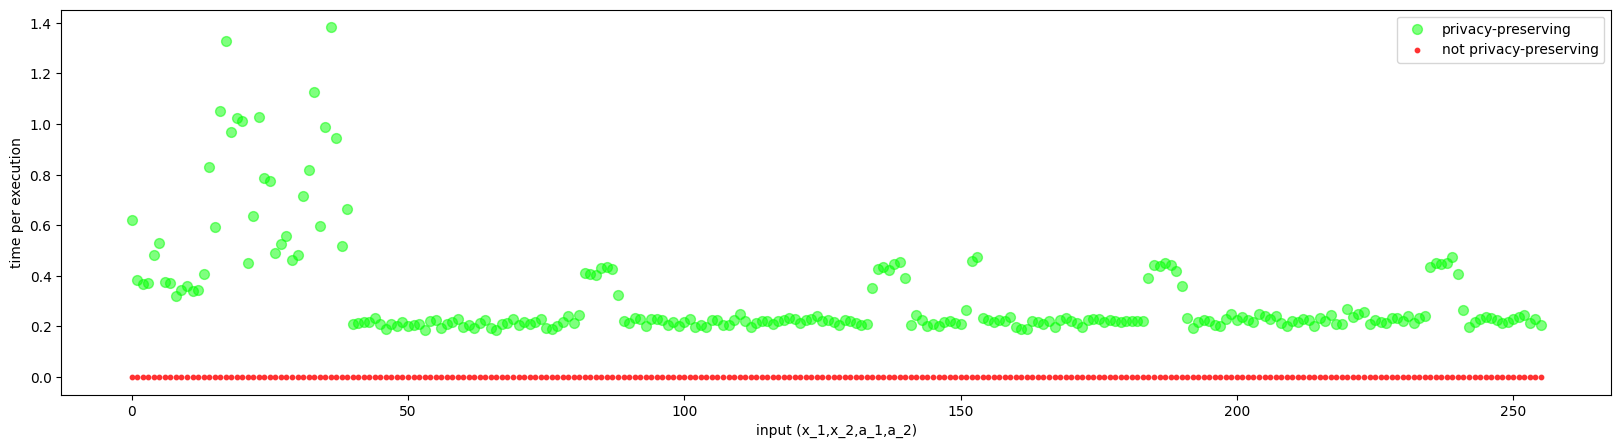

In [11]:
plot(pp_time, npp_time)